In [ ]:
!pip install tensorflow-gpu==1.15.2

In [ ]:
!pip install numpy==1.19.5

In [ ]:
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 86
Unpacking objects: 100% (89/89), done.


In [ ]:
cd stylegan/

/content/stylegan


## Downloading datset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Диплом/data.zip

## Preprocessing the dataset

In [ ]:
!mkdir mugshots

In [ ]:
import pandas as pd
import os
import pickle
import numpy as np
from PIL import Image
import dnnlib
# import dnnlib.tflib as tflib
import config


def load_data(path):
  labels = pd.read_csv('data/labels_utf8.csv', header=0, index_col=None, squeeze=True)
  labels = labels[labels["Sex Offender"] == True]
  labels = labels[labels["Race"] != "Not Available"]
  labels = labels[labels["Race"] != "Bi-Racial"]
  labels = labels[["ID", "Sex", "Race"]]
  sex_to_idx = {'Female': 1, 'Male': 0}
  race_to_idx = {'Amer Indian': 0,
                'Asian': 0.25,
                'Black': 0.5,
                'Hispanic': 0.75,
                'White': 1}
  labels = labels.replace({"Sex": sex_to_idx})
  labels = labels.replace({"Race": race_to_idx})
  files = os.listdir(os.path.join(path, 'front/'))
  imgs=[]
  for i in range(len(files)):
    if ".DS_Store" in files[i]:
      continue
    imgs.append(files[i])
  X = []
  y = []
  print(len(imgs))
  for i in range(len(imgs)):
    im = Image.open(os.path.join(path, 'front/', imgs[i]))
    longer_side = max(im.size)
    horizontal_padding = (longer_side - im.size[0]) / 2
    vertical_padding = (longer_side - im.size[1]) / 2
    #f, e = os.path.splitext(path+item)
    imResize = im.crop(
    (
        -horizontal_padding,
        -vertical_padding,
        im.size[0] + horizontal_padding,
        im.size[1] + vertical_padding
    )
    )
    RGB = imResize.convert('RGB')
    little = RGB.resize((512,512), Image.ANTIALIAS)
    id = imgs[i][:6]
    little.save("mugshots/" + id +'.jpg', 'JPEG', quality=90)
  
load_data("data/")

70008


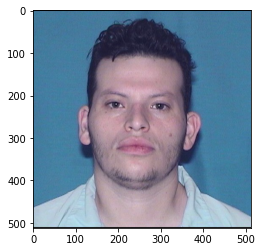

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('mugshots/R62458.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
!python dataset_tool.py create_from_images datasets/smalls/ mugshots/

## Setting up training parameters

In [ ]:
cd training/

[Errno 2] No such file or directory: 'training/'
/content


In [ ]:
%%writefile training_loop.py 
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Main training script."""

import os
import numpy as np
import tensorflow as tf
import dnnlib
import dnnlib.tflib as tflib
from dnnlib.tflib.autosummary import autosummary

import config
import train
from training import dataset
from training import misc
from metrics import metric_base

#----------------------------------------------------------------------------
# Just-in-time processing of training images before feeding them to the networks.

def process_reals(x, lod, mirror_augment, drange_data, drange_net):
    with tf.name_scope('ProcessReals'):
        with tf.name_scope('DynamicRange'):
            x = tf.cast(x, tf.float32)
            x = misc.adjust_dynamic_range(x, drange_data, drange_net)
        if mirror_augment:
            with tf.name_scope('MirrorAugment'):
                s = tf.shape(x)
                mask = tf.random_uniform([s[0], 1, 1, 1], 0.0, 1.0)
                mask = tf.tile(mask, [1, s[1], s[2], s[3]])
                x = tf.where(mask < 0.5, x, tf.reverse(x, axis=[3]))
        with tf.name_scope('FadeLOD'): # Smooth crossfade between consecutive levels-of-detail.
            s = tf.shape(x)
            y = tf.reshape(x, [-1, s[1], s[2]//2, 2, s[3]//2, 2])
            y = tf.reduce_mean(y, axis=[3, 5], keepdims=True)
            y = tf.tile(y, [1, 1, 1, 2, 1, 2])
            y = tf.reshape(y, [-1, s[1], s[2], s[3]])
            x = tflib.lerp(x, y, lod - tf.floor(lod))
        with tf.name_scope('UpscaleLOD'): # Upscale to match the expected input/output size of the networks.
            s = tf.shape(x)
            factor = tf.cast(2 ** tf.floor(lod), tf.int32)
            x = tf.reshape(x, [-1, s[1], s[2], 1, s[3], 1])
            x = tf.tile(x, [1, 1, 1, factor, 1, factor])
            x = tf.reshape(x, [-1, s[1], s[2] * factor, s[3] * factor])
        return x

#----------------------------------------------------------------------------
# Evaluate time-varying training parameters.

def training_schedule(
    cur_nimg,
    training_set,
    num_gpus,
    lod_initial_resolution  = 4,        # Image resolution used at the beginning.
    lod_training_kimg       = 600,      # Thousands of real images to show before doubling the resolution.
    lod_transition_kimg     = 600,      # Thousands of real images to show when fading in new layers.
    minibatch_base          = 16,       # Maximum minibatch size, divided evenly among GPUs.
    minibatch_dict          = {},       # Resolution-specific overrides.
    max_minibatch_per_gpu   = {},       # Resolution-specific maximum minibatch size per GPU.
    G_lrate_base            = 0.001,    # Learning rate for the generator.
    G_lrate_dict            = {},       # Resolution-specific overrides.
    D_lrate_base            = 0.001,    # Learning rate for the discriminator.
    D_lrate_dict            = {},       # Resolution-specific overrides.
    lrate_rampup_kimg       = 0,        # Duration of learning rate ramp-up.
    tick_kimg_base          = 160,      # Default interval of progress snapshots.
    tick_kimg_dict          = {4: 160, 8:140, 16:120, 32:100, 64:80, 128:60, 256:40, 512:30, 1024:20}): # Resolution-specific overrides.

    # Initialize result dict.
    s = dnnlib.EasyDict()
    s.kimg = cur_nimg / 1000.0

    # Training phase.
    phase_dur = lod_training_kimg + lod_transition_kimg
    phase_idx = int(np.floor(s.kimg / phase_dur)) if phase_dur > 0 else 0
    phase_kimg = s.kimg - phase_idx * phase_dur

    # Level-of-detail and resolution.
    s.lod = training_set.resolution_log2
    s.lod -= np.floor(np.log2(lod_initial_resolution))
    s.lod -= phase_idx
    if lod_transition_kimg > 0:
        s.lod -= max(phase_kimg - lod_training_kimg, 0.0) / lod_transition_kimg
    s.lod = max(s.lod, 0.0)
    s.resolution = 2 ** (training_set.resolution_log2 - int(np.floor(s.lod)))

    # Minibatch size.
    s.minibatch = minibatch_dict.get(s.resolution, minibatch_base)
    s.minibatch -= s.minibatch % num_gpus
    if s.resolution in max_minibatch_per_gpu:
        s.minibatch = min(s.minibatch, max_minibatch_per_gpu[s.resolution] * num_gpus)

    # Learning rate.
    s.G_lrate = G_lrate_dict.get(s.resolution, G_lrate_base)
    s.D_lrate = D_lrate_dict.get(s.resolution, D_lrate_base)
    if lrate_rampup_kimg > 0:
        rampup = min(s.kimg / lrate_rampup_kimg, 1.0)
        s.G_lrate *= rampup
        s.D_lrate *= rampup

    # Other parameters.
    s.tick_kimg = tick_kimg_dict.get(s.resolution, tick_kimg_base)
    return s

#----------------------------------------------------------------------------
# Main training script.

def training_loop(
    submit_config,
    G_args                  = {},       # Options for generator network.
    D_args                  = {},       # Options for discriminator network.
    G_opt_args              = {},       # Options for generator optimizer.
    D_opt_args              = {},       # Options for discriminator optimizer.
    G_loss_args             = {},       # Options for generator loss.
    D_loss_args             = {},       # Options for discriminator loss.
    dataset_args            = {},       # Options for dataset.load_dataset().
    sched_args              = {},       # Options for train.TrainingSchedule.
    grid_args               = {},       # Options for train.setup_snapshot_image_grid().
    metric_arg_list         = [],       # Options for MetricGroup.
    tf_config               = {},       # Options for tflib.init_tf().
    G_smoothing_kimg        = 10.0,     # Half-life of the running average of generator weights.
    D_repeats               = 1,        # How many times the discriminator is trained per G iteration.
    minibatch_repeats       = 4,        # Number of minibatches to run before adjusting training parameters.
    reset_opt_for_new_lod   = True,     # Reset optimizer internal state (e.g. Adam moments) when new layers are introduced?
    total_kimg              = 5000,    # Total length of the training, measured in thousands of real images.
    mirror_augment          = False,    # Enable mirror augment?
    drange_net              = [-1,1],   # Dynamic range used when feeding image data to the networks.
    image_snapshot_ticks    = 1,        # How often to export image snapshots?
    network_snapshot_ticks  = 1,       # How often to export network snapshots?
    save_tf_graph           = False,    # Include full TensorFlow computation graph in the tfevents file?
    save_weight_histograms  = False,    # Include weight histograms in the tfevents file?
    resume_run_id           = None, #"/content/stylegan/results/00000-sgan-custom-1gpu/network-final.pkl",     # Run ID or network pkl to resume training from, None = start from scratch.
    resume_snapshot         = None,     # Snapshot index to resume training from, None = autodetect.
    resume_kimg             = 0.0,      # Assumed training progress at the beginning. Affects reporting and training schedule.
    resume_time             = 0.0):     # Assumed wallclock time at the beginning. Affects reporting.

    # Initialize dnnlib and TensorFlow.
    ctx = dnnlib.RunContext(submit_config, train)
    tflib.init_tf(tf_config)

    # Load training set.
    training_set = dataset.load_dataset(data_dir=config.data_dir, verbose=True, **dataset_args)

    # Construct networks.
    with tf.device('/gpu:0'):
        if resume_run_id is not None:
            network_pkl = misc.locate_network_pkl(resume_run_id, resume_snapshot)
            print('Loading networks from "%s"...' % network_pkl)
            G, D, Gs = misc.load_pkl(network_pkl)
        else:
            print('Constructing networks...')
            G = tflib.Network('G', num_channels=training_set.shape[0], resolution=training_set.shape[1], label_size=training_set.label_size, **G_args)
            D = tflib.Network('D', num_channels=training_set.shape[0], resolution=training_set.shape[1], label_size=training_set.label_size, **D_args)
            Gs = G.clone('Gs')
    G.print_layers(); D.print_layers()

    print('Building TensorFlow graph...')
    with tf.name_scope('Inputs'), tf.device('/cpu:0'):
        lod_in          = tf.placeholder(tf.float32, name='lod_in', shape=[])
        lrate_in        = tf.placeholder(tf.float32, name='lrate_in', shape=[])
        minibatch_in    = tf.placeholder(tf.int32, name='minibatch_in', shape=[])
        minibatch_split = minibatch_in // submit_config.num_gpus
        Gs_beta         = 0.5 ** tf.div(tf.cast(minibatch_in, tf.float32), G_smoothing_kimg * 1000.0) if G_smoothing_kimg > 0.0 else 0.0

    G_opt = tflib.Optimizer(name='TrainG', learning_rate=lrate_in, **G_opt_args)
    D_opt = tflib.Optimizer(name='TrainD', learning_rate=lrate_in, **D_opt_args)
    for gpu in range(submit_config.num_gpus):
        with tf.name_scope('GPU%d' % gpu), tf.device('/gpu:%d' % gpu):
            G_gpu = G if gpu == 0 else G.clone(G.name + '_shadow')
            D_gpu = D if gpu == 0 else D.clone(D.name + '_shadow')
            lod_assign_ops = [tf.assign(G_gpu.find_var('lod'), lod_in), tf.assign(D_gpu.find_var('lod'), lod_in)]
            reals, labels = training_set.get_minibatch_tf()
            reals = process_reals(reals, lod_in, mirror_augment, training_set.dynamic_range, drange_net)
            with tf.name_scope('G_loss'), tf.control_dependencies(lod_assign_ops):
                G_loss = dnnlib.util.call_func_by_name(G=G_gpu, D=D_gpu, opt=G_opt, training_set=training_set, minibatch_size=minibatch_split, **G_loss_args)
            with tf.name_scope('D_loss'), tf.control_dependencies(lod_assign_ops):
                D_loss = dnnlib.util.call_func_by_name(G=G_gpu, D=D_gpu, opt=D_opt, training_set=training_set, minibatch_size=minibatch_split, reals=reals, labels=labels, **D_loss_args)
            G_opt.register_gradients(tf.reduce_mean(G_loss), G_gpu.trainables)
            D_opt.register_gradients(tf.reduce_mean(D_loss), D_gpu.trainables)
    G_train_op = G_opt.apply_updates()
    D_train_op = D_opt.apply_updates()

    Gs_update_op = Gs.setup_as_moving_average_of(G, beta=Gs_beta)
    with tf.device('/gpu:0'):
        try:
            peak_gpu_mem_op = tf.contrib.memory_stats.MaxBytesInUse()
        except tf.errors.NotFoundError:
            peak_gpu_mem_op = tf.constant(0)

    print('Setting up snapshot image grid...')
    grid_size, grid_reals, grid_labels, grid_latents = misc.setup_snapshot_image_grid(G, training_set, **grid_args)
    sched = training_schedule(cur_nimg=total_kimg*1000, training_set=training_set, num_gpus=submit_config.num_gpus, **sched_args)
    grid_fakes = Gs.run(grid_latents, grid_labels, is_validation=True, minibatch_size=sched.minibatch//submit_config.num_gpus)

    print('Setting up run dir...')
    misc.save_image_grid(grid_reals, os.path.join(submit_config.run_dir, 'reals.png'), drange=training_set.dynamic_range, grid_size=grid_size)
    misc.save_image_grid(grid_fakes, os.path.join(submit_config.run_dir, 'fakes%06d.png' % resume_kimg), drange=drange_net, grid_size=grid_size)
    summary_log = tf.summary.FileWriter(submit_config.run_dir)
    if save_tf_graph:
        summary_log.add_graph(tf.get_default_graph())
    if save_weight_histograms:
        G.setup_weight_histograms(); D.setup_weight_histograms()
    metrics = metric_base.MetricGroup(metric_arg_list)

    print('Training...\n')
    ctx.update('', cur_epoch=resume_kimg, max_epoch=total_kimg)
    maintenance_time = ctx.get_last_update_interval()
    cur_nimg = int(resume_kimg * 1000)
    cur_tick = 0
    tick_start_nimg = cur_nimg
    prev_lod = -1.0
    while cur_nimg < total_kimg * 1000:
        if ctx.should_stop(): break

        # Choose training parameters and configure training ops.
        sched = training_schedule(cur_nimg=cur_nimg, training_set=training_set, num_gpus=submit_config.num_gpus, **sched_args)
        training_set.configure(sched.minibatch // submit_config.num_gpus, sched.lod)
        if reset_opt_for_new_lod:
            if np.floor(sched.lod) != np.floor(prev_lod) or np.ceil(sched.lod) != np.ceil(prev_lod):
                G_opt.reset_optimizer_state(); D_opt.reset_optimizer_state()
        prev_lod = sched.lod

        # Run training ops.
        for _mb_repeat in range(minibatch_repeats):
            for _D_repeat in range(D_repeats):
                tflib.run([D_train_op, Gs_update_op], {lod_in: sched.lod, lrate_in: sched.D_lrate, minibatch_in: sched.minibatch})
                cur_nimg += sched.minibatch
            tflib.run([G_train_op], {lod_in: sched.lod, lrate_in: sched.G_lrate, minibatch_in: sched.minibatch})

        # Perform maintenance tasks once per tick.
        done = (cur_nimg >= total_kimg * 1000)
        if cur_nimg >= tick_start_nimg + sched.tick_kimg * 1000 or done:
            cur_tick += 1
            tick_kimg = (cur_nimg - tick_start_nimg) / 1000.0
            tick_start_nimg = cur_nimg
            tick_time = ctx.get_time_since_last_update()
            total_time = ctx.get_time_since_start() + resume_time

            # Report progress.
            print('tick %-5d kimg %-8.1f lod %-5.2f minibatch %-4d time %-12s sec/tick %-7.1f sec/kimg %-7.2f maintenance %-6.1f gpumem %-4.1f' % (
                autosummary('Progress/tick', cur_tick),
                autosummary('Progress/kimg', cur_nimg / 1000.0),
                autosummary('Progress/lod', sched.lod),
                autosummary('Progress/minibatch', sched.minibatch),
                dnnlib.util.format_time(autosummary('Timing/total_sec', total_time)),
                autosummary('Timing/sec_per_tick', tick_time),
                autosummary('Timing/sec_per_kimg', tick_time / tick_kimg),
                autosummary('Timing/maintenance_sec', maintenance_time),
                autosummary('Resources/peak_gpu_mem_gb', peak_gpu_mem_op.eval() / 2**30)))
            autosummary('Timing/total_hours', total_time / (60.0 * 60.0))
            autosummary('Timing/total_days', total_time / (24.0 * 60.0 * 60.0))

            # Save snapshots.
            if cur_tick % image_snapshot_ticks == 0 or done:
                grid_fakes = Gs.run(grid_latents, grid_labels, is_validation=True, minibatch_size=sched.minibatch//submit_config.num_gpus)
                misc.save_image_grid(grid_fakes, os.path.join(submit_config.run_dir, 'fakes%06d.png' % (cur_nimg // 1000)), drange=drange_net, grid_size=grid_size)
            if cur_tick % network_snapshot_ticks == 0 or done or cur_tick == 1:
                pkl = os.path.join(submit_config.run_dir, 'network-snapshot-%06d.pkl' % (cur_nimg // 1000))
                misc.save_pkl((G, D, Gs), pkl)
                metrics.run(pkl, run_dir=submit_config.run_dir, num_gpus=submit_config.num_gpus, tf_config=tf_config)

            # Update summaries and RunContext.
            metrics.update_autosummaries()
            tflib.autosummary.save_summaries(summary_log, cur_nimg)
            ctx.update('%.2f' % sched.lod, cur_epoch=cur_nimg // 1000, max_epoch=total_kimg)
            maintenance_time = ctx.get_last_update_interval() - tick_time

    # Write final results.
    misc.save_pkl((G, D, Gs), os.path.join(submit_config.run_dir, 'network-final.pkl'))
    summary_log.close()

    ctx.close()

#----------------------------------------------------------------------------


Overwriting training_loop.py


In [ ]:
cd ..

/content/stylegan


In [ ]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Main entry point for training StyleGAN and ProGAN networks."""

import copy
import dnnlib
from dnnlib import EasyDict

import config
import metrics

#----------------------------------------------------------------------------
# Official training configs for StyleGAN, targeted mainly for FFHQ.

if 1:
    desc          = 'sgan'                                                                 # Description string included in result subdir name.
    train         = EasyDict(run_func_name='training.training_loop.training_loop')         # Options for training loop.
    G             = EasyDict(func_name='training.networks_stylegan.G_style')               # Options for generator network.
    D             = EasyDict(func_name='training.networks_stylegan.D_basic')               # Options for discriminator network.
    G_opt         = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                          # Options for generator optimizer.
    D_opt         = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                          # Options for discriminator optimizer.
    G_loss        = EasyDict(func_name='training.loss.G_logistic_nonsaturating')           # Options for generator loss.
    D_loss        = EasyDict(func_name='training.loss.D_logistic_simplegp', r1_gamma=10.0) # Options for discriminator loss.
    dataset       = EasyDict()                                                             # Options for load_dataset().
    sched         = EasyDict()                                                             # Options for TrainingSchedule.
    grid          = EasyDict(size='4k', layout='random')                                   # Options for setup_snapshot_image_grid().
    #metrics       = [metric_base.fid50k]                                                   # Options for MetricGroup.
    submit_config = dnnlib.SubmitConfig()                                                  # Options for dnnlib.submit_run().
    tf_config     = {'rnd.np_random_seed': 1000}                                           # Options for tflib.init_tf().

    # Dataset.
    desc += '-custom';     dataset = EasyDict(tfrecord_dir='smalls', resolution=512);              train.mirror_augment = True
    #desc += '-celebahq'; dataset = EasyDict(tfrecord_dir='celebahq');          train.mirror_augment = True
    #desc += '-bedroom';  dataset = EasyDict(tfrecord_dir='lsun-bedroom-full'); train.mirror_augment = False
    #desc += '-car';      dataset = EasyDict(tfrecord_dir='lsun-car-512x384');  train.mirror_augment = False
    #desc += '-cat';      dataset = EasyDict(tfrecord_dir='lsun-cat-full');     train.mirror_augment = False

    # Number of GPUs.
    desc += '-1gpu'; submit_config.num_gpus = 1; sched.minibatch_base = 4; sched.minibatch_dict = {4: 128, 8: 128, 16: 128, 32: 64, 64: 32, 128: 16, 256: 8, 512: 4}
    #desc += '-2gpu'; submit_config.num_gpus = 2; sched.minibatch_base = 8; sched.minibatch_dict = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16, 256: 8}
    #desc += '-4gpu'; submit_config.num_gpus = 4; sched.minibatch_base = 16; sched.minibatch_dict = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}
    #desc += '-8gpu'; submit_config.num_gpus = 8; sched.minibatch_base = 32; sched.minibatch_dict = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32}

    # Default options.
    train.total_kimg = 4000
    sched.lod_initial_resolution = 8
    sched.G_lrate_dict = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
    sched.D_lrate_dict = EasyDict(sched.G_lrate_dict)

    # WGAN-GP loss for CelebA-HQ.
    #desc += '-wgangp'; G_loss = EasyDict(func_name='training.loss.G_wgan'); D_loss = EasyDict(func_name='training.loss.D_wgan_gp'); sched.G_lrate_dict = {k: min(v, 0.002) for k, v in sched.G_lrate_dict.items()}; sched.D_lrate_dict = EasyDict(sched.G_lrate_dict)

    # Table 1.
    #desc += '-tuned-baseline'; G.use_styles = False; G.use_pixel_norm = True; G.use_instance_norm = False; G.mapping_layers = 0; G.truncation_psi = None; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-add-mapping-and-styles'; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-remove-traditional-input'; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-add-noise-inputs'; G.style_mixing_prob = 0.0
    #desc += '-mixing-regularization' # default

    # Table 2.
    #desc += '-mix0'; G.style_mixing_prob = 0.0
    #desc += '-mix50'; G.style_mixing_prob = 0.5
    #desc += '-mix90'; G.style_mixing_prob = 0.9 # default
    #desc += '-mix100'; G.style_mixing_prob = 1.0

    # Table 4.
    #desc += '-traditional-0'; G.use_styles = False; G.use_pixel_norm = True; G.use_instance_norm = False; G.mapping_layers = 0; G.truncation_psi = None; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-traditional-8'; G.use_styles = False; G.use_pixel_norm = True; G.use_instance_norm = False; G.mapping_layers = 8; G.truncation_psi = None; G.const_input_layer = False; G.style_mixing_prob = 0.0; G.use_noise = False
    #desc += '-stylebased-0'; G.mapping_layers = 0
    #desc += '-stylebased-1'; G.mapping_layers = 1
    #desc += '-stylebased-2'; G.mapping_layers = 2
    #desc += '-stylebased-8'; G.mapping_layers = 8 # default

#----------------------------------------------------------------------------
# Official training configs for Progressive GAN, targeted mainly for CelebA-HQ.

if 0:
    desc          = 'pgan'                                                         # Description string included in result subdir name.
    train         = EasyDict(run_func_name='training.training_loop.training_loop') # Options for training loop.
    G             = EasyDict(func_name='training.networks_progan.G_paper')         # Options for generator network.
    D             = EasyDict(func_name='training.networks_progan.D_paper')         # Options for discriminator network.
    G_opt         = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                  # Options for generator optimizer.
    D_opt         = EasyDict(beta1=0.0, beta2=0.99, epsilon=1e-8)                  # Options for discriminator optimizer.
    G_loss        = EasyDict(func_name='training.loss.G_wgan')                     # Options for generator loss.
    D_loss        = EasyDict(func_name='training.loss.D_wgan_gp')                  # Options for discriminator loss.
    dataset       = EasyDict()                                                     # Options for load_dataset().
    sched         = EasyDict()                                                     # Options for TrainingSchedule.
    grid          = EasyDict(size='1080p', layout='random')                        # Options for setup_snapshot_image_grid().
    #metrics       = [metric_base.fid50k]                                           # Options for MetricGroup.
    submit_config = dnnlib.SubmitConfig()                                          # Options for dnnlib.submit_run().
    tf_config     = {'rnd.np_random_seed': 1000}                                   # Options for tflib.init_tf().

    # Dataset (choose one).
    #desc += '-celebahq';            dataset = EasyDict(tfrecord_dir='celebahq'); train.mirror_augment = True
    #desc += '-celeba';              dataset = EasyDict(tfrecord_dir='celeba'); train.mirror_augment = True
    #desc += '-cifar10';             dataset = EasyDict(tfrecord_dir='cifar10')
    #desc += '-cifar100';            dataset = EasyDict(tfrecord_dir='cifar100')
    #desc += '-svhn';                dataset = EasyDict(tfrecord_dir='svhn')
    #desc += '-mnist';               dataset = EasyDict(tfrecord_dir='mnist')
    #desc += '-mnistrgb';            dataset = EasyDict(tfrecord_dir='mnistrgb')
    #desc += '-syn1024rgb';          dataset = EasyDict(class_name='training.dataset.SyntheticDataset', resolution=1024, num_channels=3)
    #desc += '-lsun-airplane';       dataset = EasyDict(tfrecord_dir='lsun-airplane-100k');       train.mirror_augment = True
    #desc += '-lsun-bedroom';        dataset = EasyDict(tfrecord_dir='lsun-bedroom-100k');        train.mirror_augment = True
    #desc += '-lsun-bicycle';        dataset = EasyDict(tfrecord_dir='lsun-bicycle-100k');        train.mirror_augment = True
    #desc += '-lsun-bird';           dataset = EasyDict(tfrecord_dir='lsun-bird-100k');           train.mirror_augment = True
    #desc += '-lsun-boat';           dataset = EasyDict(tfrecord_dir='lsun-boat-100k');           train.mirror_augment = True
    #desc += '-lsun-bottle';         dataset = EasyDict(tfrecord_dir='lsun-bottle-100k');         train.mirror_augment = True
    #desc += '-lsun-bridge';         dataset = EasyDict(tfrecord_dir='lsun-bridge-100k');         train.mirror_augment = True
    #desc += '-lsun-bus';            dataset = EasyDict(tfrecord_dir='lsun-bus-100k');            train.mirror_augment = True
    #desc += '-lsun-car';            dataset = EasyDict(tfrecord_dir='lsun-car-100k');            train.mirror_augment = True
    #desc += '-lsun-cat';            dataset = EasyDict(tfrecord_dir='lsun-cat-100k');            train.mirror_augment = True
    #desc += '-lsun-chair';          dataset = EasyDict(tfrecord_dir='lsun-chair-100k');          train.mirror_augment = True
    #desc += '-lsun-churchoutdoor';  dataset = EasyDict(tfrecord_dir='lsun-churchoutdoor-100k');  train.mirror_augment = True
    #desc += '-lsun-classroom';      dataset = EasyDict(tfrecord_dir='lsun-classroom-100k');      train.mirror_augment = True
    #desc += '-lsun-conferenceroom'; dataset = EasyDict(tfrecord_dir='lsun-conferenceroom-100k'); train.mirror_augment = True
    #desc += '-lsun-cow';            dataset = EasyDict(tfrecord_dir='lsun-cow-100k');            train.mirror_augment = True
    #desc += '-lsun-diningroom';     dataset = EasyDict(tfrecord_dir='lsun-diningroom-100k');     train.mirror_augment = True
    #desc += '-lsun-diningtable';    dataset = EasyDict(tfrecord_dir='lsun-diningtable-100k');    train.mirror_augment = True
    #desc += '-lsun-dog';            dataset = EasyDict(tfrecord_dir='lsun-dog-100k');            train.mirror_augment = True
    #desc += '-lsun-horse';          dataset = EasyDict(tfrecord_dir='lsun-horse-100k');          train.mirror_augment = True
    #desc += '-lsun-kitchen';        dataset = EasyDict(tfrecord_dir='lsun-kitchen-100k');        train.mirror_augment = True
    #desc += '-lsun-livingroom';     dataset = EasyDict(tfrecord_dir='lsun-livingroom-100k');     train.mirror_augment = True
    #desc += '-lsun-motorbike';      dataset = EasyDict(tfrecord_dir='lsun-motorbike-100k');      train.mirror_augment = True
    #desc += '-lsun-person';         dataset = EasyDict(tfrecord_dir='lsun-person-100k');         train.mirror_augment = True
    #desc += '-lsun-pottedplant';    dataset = EasyDict(tfrecord_dir='lsun-pottedplant-100k');    train.mirror_augment = True
    #desc += '-lsun-restaurant';     dataset = EasyDict(tfrecord_dir='lsun-restaurant-100k');     train.mirror_augment = True
    #desc += '-lsun-sheep';          dataset = EasyDict(tfrecord_dir='lsun-sheep-100k');          train.mirror_augment = True
    #desc += '-lsun-sofa';           dataset = EasyDict(tfrecord_dir='lsun-sofa-100k');           train.mirror_augment = True
    #desc += '-lsun-tower';          dataset = EasyDict(tfrecord_dir='lsun-tower-100k');          train.mirror_augment = True
    #desc += '-lsun-train';          dataset = EasyDict(tfrecord_dir='lsun-train-100k');          train.mirror_augment = True
    #desc += '-lsun-tvmonitor';      dataset = EasyDict(tfrecord_dir='lsun-tvmonitor-100k');      train.mirror_augment = True

    # Conditioning & snapshot options.
    #desc += '-cond'; dataset.max_label_size = 'full' # conditioned on full label
    #desc += '-cond1'; dataset.max_label_size = 1 # conditioned on first component of the label
    #desc += '-g4k'; grid.size = '4k'
    #desc += '-grpc'; grid.layout = 'row_per_class'

    # Config presets (choose one).
    #desc += '-preset-v1-1gpu'; submit_config.num_gpus = 1; D.mbstd_group_size = 16; sched.minibatch_base = 16; sched.minibatch_dict = {256: 14, 512: 6, 1024: 3}; sched.lod_training_kimg = 800; sched.lod_transition_kimg = 800; train.total_kimg = 19000
    #desc += '-preset-v2-1gpu'; submit_config.num_gpus = 1; sched.minibatch_base = 4; sched.minibatch_dict = {4: 128, 8: 128, 16: 128, 32: 64, 64: 32, 128: 16, 256: 8, 512: 4}; sched.G_lrate_dict = {1024: 0.0015}; sched.D_lrate_dict = EasyDict(sched.G_lrate_dict); train.total_kimg = 12000
    #desc += '-preset-v2-2gpus'; submit_config.num_gpus = 2; sched.minibatch_base = 8; sched.minibatch_dict = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16, 256: 8}; sched.G_lrate_dict = {512: 0.0015, 1024: 0.002}; sched.D_lrate_dict = EasyDict(sched.G_lrate_dict); train.total_kimg = 12000
    #desc += '-preset-v2-4gpus'; submit_config.num_gpus = 4; sched.minibatch_base = 16; sched.minibatch_dict = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}; sched.G_lrate_dict = {256: 0.0015, 512: 0.002, 1024: 0.003}; sched.D_lrate_dict = EasyDict(sched.G_lrate_dict); train.total_kimg = 12000
    #desc += '-preset-v2-8gpus'; submit_config.num_gpus = 8; sched.minibatch_base = 32; sched.minibatch_dict = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32}; sched.G_lrate_dict = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}; sched.D_lrate_dict = EasyDict(sched.G_lrate_dict); train.total_kimg = 12000

    # Numerical precision (choose one).
    #desc += '-fp32'; sched.max_minibatch_per_gpu = {256: 16, 512: 8, 1024: 4}
    #desc += '-fp16'; G.dtype = 'float16'; D.dtype = 'float16'; G.pixelnorm_epsilon=1e-4; G_opt.use_loss_scaling = True; D_opt.use_loss_scaling = True; sched.max_minibatch_per_gpu = {512: 16, 1024: 8}

    # Disable individual features.
    #desc += '-nogrowing'; sched.lod_initial_resolution = 1024; sched.lod_training_kimg = 0; sched.lod_transition_kimg = 0; train.total_kimg = 10000
    #desc += '-nopixelnorm'; G.use_pixelnorm = False
    #desc += '-nowscale'; G.use_wscale = False; D.use_wscale = False
    #desc += '-noleakyrelu'; G.use_leakyrelu = False
    #desc += '-nosmoothing'; train.G_smoothing_kimg = 0.0
    #desc += '-norepeat'; train.minibatch_repeats = 1
    #desc += '-noreset'; train.reset_opt_for_new_lod = False

    # Special modes.
    #desc += '-BENCHMARK'; sched.lod_initial_resolution = 4; sched.lod_training_kimg = 3; sched.lod_transition_kimg = 3; train.total_kimg = (8*2+1)*3; sched.tick_kimg_base = 1; sched.tick_kimg_dict = {}; train.image_snapshot_ticks = 1000; train.network_snapshot_ticks = 1000
    #desc += '-BENCHMARK0'; sched.lod_initial_resolution = 1024; train.total_kimg = 10; sched.tick_kimg_base = 1; sched.tick_kimg_dict = {}; train.image_snapshot_ticks = 1000; train.network_snapshot_ticks = 1000
    #desc += '-VERBOSE'; sched.tick_kimg_base = 1; sched.tick_kimg_dict = {}; train.image_snapshot_ticks = 1; train.network_snapshot_ticks = 100
    #desc += '-GRAPH'; train.save_tf_graph = True
    #desc += '-HIST'; train.save_weight_histograms = True

#----------------------------------------------------------------------------
# Main entry point for training.
# Calls the function indicated by 'train' using the selected options.

def main():
    kwargs = EasyDict(train)
    kwargs.update(G_args=G, D_args=D, G_opt_args=G_opt, D_opt_args=D_opt, G_loss_args=G_loss, D_loss_args=D_loss)
    kwargs.update(dataset_args=dataset, sched_args=sched, grid_args=grid, tf_config=tf_config)
    kwargs.submit_config = copy.deepcopy(submit_config)
    kwargs.submit_config.run_dir_root = dnnlib.submission.submit.get_template_from_path(config.result_dir)
    kwargs.submit_config.run_dir_ignore += config.run_dir_ignore
    kwargs.submit_config.run_desc = desc
    dnnlib.submit_run(**kwargs)

## Training

In [ ]:
#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()

#----------------------------------------------------------------------------

## Testing

In [ ]:
import os
import pickle
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
from tqdm import tqdm_notebook as tqdm

tflib.init_tf()

In [ ]:
model = '/content/stylegan/network-snapshot-001500.pkl'

with open(model, 'rb') as f:
    _G, _D, Gs = pickle.load(f)

fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

In [ ]:
truncation = 0.5
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    plt.axis('off')
    return images, latents

images, latents = random_sample(6, scale=3)